# dominating set

Set up calculations and store in EspressoDB

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising, embed_with_offset

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler

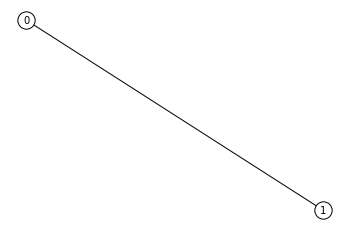

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}
Greedy solution
 {0}
Chain strength: 4.0
Solving 2/2

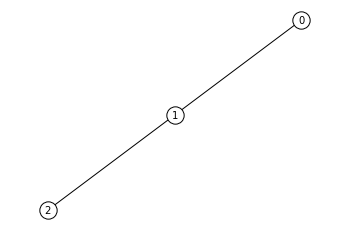

{'tag': 'NN(3)', 'total_vertices': 3, 'total_edges': 2, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2]], 'adjacency_hash': '5c6af54e077bddcd12076955a2eee364'}
Greedy solution
 {0, 2}
Chain strength: 4.0
Solving 2/2

In [4]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
#graph, tag = gt.generate_newman_watts_strogatz_graph(10, 4, 0.1)
# graph, tag = gt.generate_corona_graph(3,6)
for nvertices in range(2,13):
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))
    
    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Initial")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Rescaled")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")
    
    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)
    
    # Set offset percentage
    # set percentage to 0 for no offset
    percentage = 0.05
    
    iterations = 10
    for idx in range(iterations):
        print(f"\rSolving {idx+1}/{iterations}", end="")
        qubo_dict, embed, anneal_offsets = embed_with_offset(sampler=sampler, qubo=qubo, percentage=percentage, offset=True)

        dwave_config = {
            "annealing_time": 500,  # integer microseconds [1, 2000]
            "answer_mode": "histogram", # histogram or raw
            "auto_scale": True,
            "num_reads": 1000,  # raw will dump out all results
            "num_spin_reversal_transforms": 0,
            "readout_thermalization": 0, # default 0
            "programming_thermalization": 1000, # default 1000
            "chain_strength": chain_strength,
            "anneal_offsets": anneal_offsets
        }
        solver = "DW_2000Q_5"

        experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, percentage=percentage, qubo=qubo)

        # Solve on DWave and push to database
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        #result = insert_result(graph_params, experiment_params, data_params)

In [ ]:
graph, _ = gt.generate_corona_graph(2,0)
print(graph)
G = nx.Graph()
G.add_edges_from(graph)
draw(G)